In [1]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages

### LDL-Validation
- Need to confirm branch prior to working 
- Run on 8/25/22, pulled today 
- Working on validation and verification of LDL-C 

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()


2022-11-03 10:52:04.478 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2022-11-03 10:52:04.572 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2022-11-03 10:52:04.574 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 0'].
2022-11-03 10:52:04.578 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2022-11-03 10:52:04.901 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2022-11-03 10:52:04.901 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2022-11-03 10:52:05.260 | DEBUG    | vivarium.framework.values:_regis

In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,entrance_time,sex,alive,location,exit_time,age,years_of_life_lost,cause_of_death,years_lived_with_disability,...,post_myocardial_infarction_event_time,post_myocardial_infarction_event_count,ldlc_medication_adherence,ldlc_multiplier,ldlc_medication,sbp_medication_adherence,sbp_medication,sbp_multiplier,visit_type,scheduled_date
0,True,2020-12-04,Female,alive,Alabama,NaT,47.388882,0.0,not_dead,0.0,...,NaT,0,primary_non_adherent,1.0,no_treatment,secondary_non_adherent,no_treatment,1.0,none,NaT
1,True,2020-12-04,Male,alive,Alabama,NaT,41.564194,0.0,not_dead,0.0,...,NaT,0,secondary_non_adherent,1.0,no_treatment,adherent,no_treatment,1.0,none,NaT
2,True,2020-12-04,Female,alive,Alabama,NaT,53.155826,0.0,not_dead,0.0,...,NaT,0,primary_non_adherent,1.0,low_intensity,primary_non_adherent,one_drug_half_dose_efficacy,1.0,none,NaT
3,True,2020-12-04,Male,alive,Alabama,NaT,30.457692,0.0,not_dead,0.0,...,NaT,0,adherent,1.0,no_treatment,adherent,no_treatment,1.0,none,NaT
4,True,2020-12-04,Female,alive,Alabama,NaT,19.554806,0.0,not_dead,0.0,...,NaT,0,adherent,1.0,no_treatment,adherent,no_treatment,1.0,none,NaT


In [5]:
pop0.columns

Index(['tracked', 'entrance_time', 'sex', 'alive', 'location', 'exit_time',
       'age', 'years_of_life_lost', 'cause_of_death',
       'years_lived_with_disability', 'previous_ischemic_stroke',
       'previous_myocardial_infarction', 'previous_angina', 'angina',
       'ischemic_stroke', 'myocardial_infarction',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'susceptible_to_angina_event_time', 'susceptible_to_angina_event_count',
       'angina_event_count', 'angina_event_time',
       'susceptible_to_ischemic_stroke_event_time',
       'susceptible_to_ischemic_stroke_event_count',
       'acute_ischemic_stroke_event_time', 'acute_ischemic_stroke_event_count',
       'chronic_ischemic_stroke_event_count',
       'chronic_ischemic_stroke_event_time',
       'susceptible_to_myocardial_infarction_event_

In [6]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate',
 'affected_unmodeled.cause_specific_mortality_rate.paf',
 'disability_weight',
 'angina.incidence_rate',
 'angina.incidence_rate.paf',
 'angina.dwell_time',
 'angina.disability_weight',
 'angina.excess_mortality_rate',
 'angina.excess_mortality_rate.paf',
 'high_ldl_cholesterol.exposure',
 'acute_myocardial_infarction.incidence_rate',
 'acute_myocardial_infarction.incidence_rate.paf',
 'post_myocardial_infarction_to_acute_myocardial_infarction.transition_rate',
 'post_myocardial_infarction_to_acute_myocardial_infarction.transition_rate.paf',
 'acute_ischemic_stroke.incidence_rate',
 'acute_ischemic_stroke.incidence_rate.paf',
 'chronic_ischemic_stroke_to_acute_ischemic_stroke.transition_rate',
 'chronic_ischemic_stroke_to_acute_ischemic_stroke.transition_rate.paf',
 'high_systolic_blood_pressure.exposure',
 'acute_ischemic_stroke.dwell_time',
 'acute_ischemic_stroke.dis

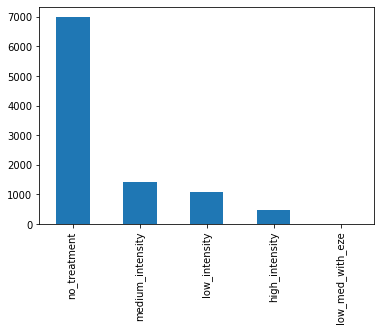

In [7]:
ax = pop0['ldlc_medication'].value_counts().plot(kind='bar')

In [8]:
sim_data = pd.DataFrame()
for step in list(range(0,12)):
    sim.step()
    pop_t = sim.get_population()
    pop_t['step'] = step
    sim_data = pd.concat([sim_data, pop_t])

2022-11-03 10:52:39.446 | DEBUG    | vivarium.framework.engine:step:172 - 2021-01-01 00:00:00
2022-11-03 10:52:56.435 | DEBUG    | vivarium.framework.engine:step:172 - 2021-01-29 00:00:00
2022-11-03 10:53:13.473 | DEBUG    | vivarium.framework.engine:step:172 - 2021-02-26 00:00:00
2022-11-03 10:53:30.656 | DEBUG    | vivarium.framework.engine:step:172 - 2021-03-26 00:00:00
2022-11-03 10:53:47.829 | DEBUG    | vivarium.framework.engine:step:172 - 2021-04-23 00:00:00
2022-11-03 10:54:05.197 | DEBUG    | vivarium.framework.engine:step:172 - 2021-05-21 00:00:00
2022-11-03 10:54:23.071 | DEBUG    | vivarium.framework.engine:step:172 - 2021-06-18 00:00:00
2022-11-03 10:54:40.119 | DEBUG    | vivarium.framework.engine:step:172 - 2021-07-16 00:00:00
2022-11-03 10:54:57.139 | DEBUG    | vivarium.framework.engine:step:172 - 2021-08-13 00:00:00
2022-11-03 10:55:14.118 | DEBUG    | vivarium.framework.engine:step:172 - 2021-09-10 00:00:00
2022-11-03 10:55:31.262 | DEBUG    | vivarium.framework.engi

In [1]:
step3 = sim_data.loc[sim_data.step == 12]

ax = step3['ldlc_medication'].value_counts().plot(kind='bar')

NameError: name 'sim_data' is not defined